In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import scipy.stats
from IPython.display import Video, display, HTML
import tqdm
import statsmodels.formula.api as sm

sns.set()

def read_csvx(path, *args, **kwargs):
    try:
        return pd.read_csv(str(path), *args, **kwargs)
    except FileNotFoundException as e:
        return pd.read_csv(str(path) +'.gz', *args, **kwargs)


def followorbit(vals, path):
    out = []
    for n in range(100):
        closest05 = np.clip(round(path[n] * 2) / 2, 0, 10)
        rank = vals.query(f'nbopp == {n} and othercoop == {closest05}')['rank'].values[0]
        out.append(rank)
    return np.array(out)

import re
def gethighest(vals, prefix="logall_", which=1):
    if which == 1:
        m = np.argmax([int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals])
    else:
        trueval = [int(re.search(f'{prefix}(\d+)', val).group(1)) for val in vals]
        itrueval = sorted(list(enumerate(trueval)), key=lambda x: x[1])
        m = itrueval[-which][0]
    return vals[m]

    
def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

def sorted_nicely(l): 
    """ Sort the given iterable in the way that humans expect.""" 
    convert = lambda text: int(text) if text.isdigit() else text 
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(l, key = alphanum_key)

def readparams(file):
    params = {} 
    with open(file) as f:
        for line in f:
            line = line[:-1]  # remove \n
            if not line or line.startswith('#') or line.startswith('import'):
                continue
            key, val = line.split('=')
            if val.lower() == 'true' or val.lower() == 'false':
                params[key] = val.lower() == 'true'
            else:
                try:
                    params[key] = float(val)
                except ValueError:
                    params[key] = val
    return params

import platform
hostname = platform.node()
print(hostname)

if hostname == 'cluster':
    prefix = '/home/ecoffet/robocoop/'
else:
    prefix = '/home/pecoffet/remoterobo/'

cluster


/home/ecoffet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/home/ecoffet/robocoop//logs/negociate25-noneone-train-fitprop/2020-07-23-1327/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_fitprop/run_01/rep00/coop_99.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-fitprop/2020-07-23-1327/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_fitprop/run_01/rep00/


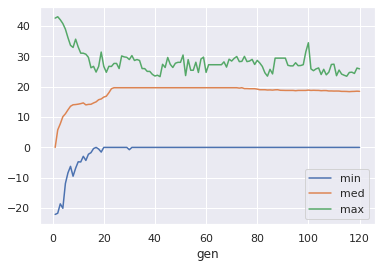

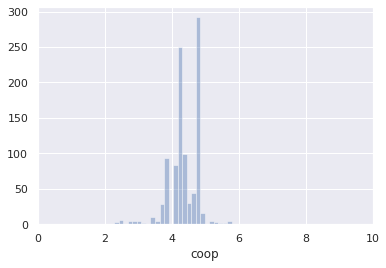

/home/ecoffet/robocoop//logs/negociate25-noneone-train-fitprop/2020-07-23-1327/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_fitprop/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-fitprop/2020-07-23-1327/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_fitprop/run_01/rep00/


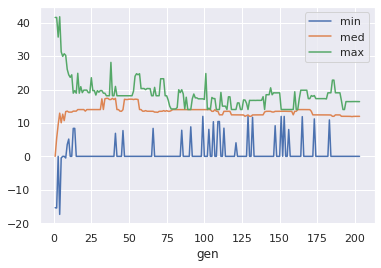

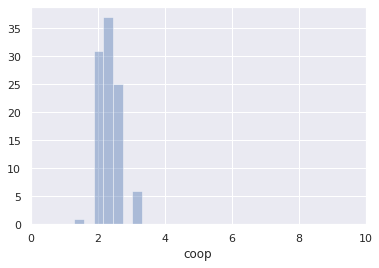

/home/ecoffet/robocoop//logs/negociate25-noneone-train-fitprop/2020-07-23-1327/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_fitprop/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-fitprop/2020-07-23-1327/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_fitprop/run_01/rep00/


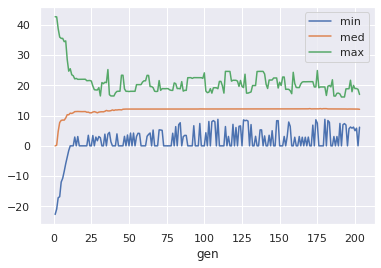

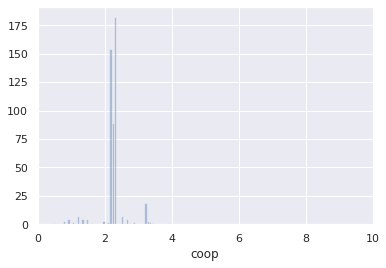

<class 'ValueError'> attempt to get argmax of an empty sequence
<class 'ValueError'> attempt to get argmax of an empty sequence
<class 'ValueError'> attempt to get argmax of an empty sequence
<class 'ValueError'> attempt to get argmax of an empty sequence
/home/ecoffet/robocoop//logs/negociate25-noneone-train-fromopti/2020-07-23-1345/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_0_noneone/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-fromopti/2020-07-23-1345/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_0_noneone/run_01/rep00/


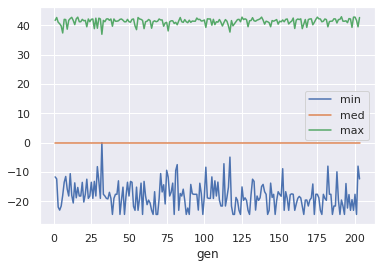

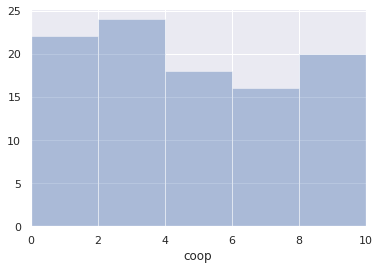

/home/ecoffet/robocoop//logs/negociate25-noneone-train-fromopti/2020-07-23-1345/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_0_noneone/run_01/rep00/coop_149.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-fromopti/2020-07-23-1345/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_0_noneone/run_01/rep00/


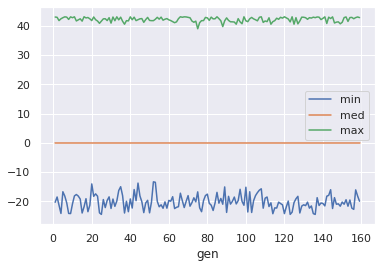

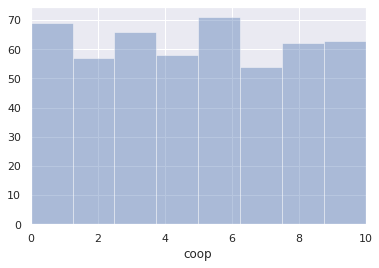

/home/ecoffet/robocoop//logs/negociate25-noneone-train-highmut/2020-07-23-1158/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.2_+mutPro_0.5_+mutRat_1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-highmut/2020-07-23-1158/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.2_+mutPro_0.5_+mutRat_1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2/run_01/rep00/


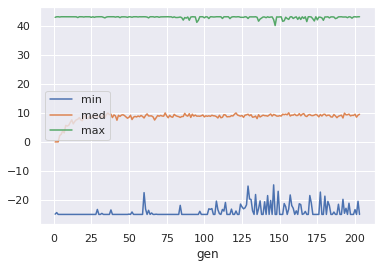

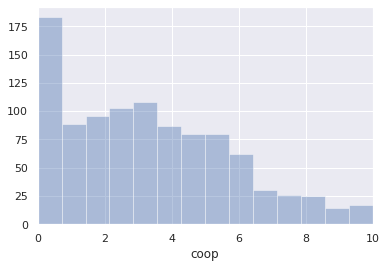

/home/ecoffet/robocoop//logs/negociate25-noneone-train-highmut/2020-07-23-1158/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.2_+mutPro_0.5_+mutRat_1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-highmut/2020-07-23-1158/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.2_+mutPro_0.5_+mutRat_1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2/run_01/rep00/


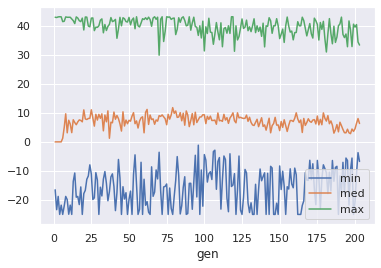

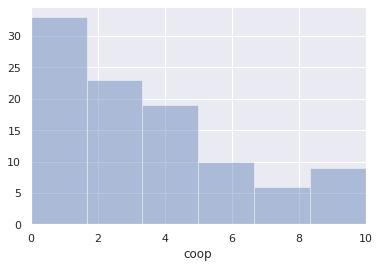

/home/ecoffet/robocoop//logs/negociate25-noneone-train-highmut/2020-07-23-1158/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.2_+mutPro_0.5_+mutRat_1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-highmut/2020-07-23-1158/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.2_+mutPro_0.5_+mutRat_1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2/run_01/rep00/


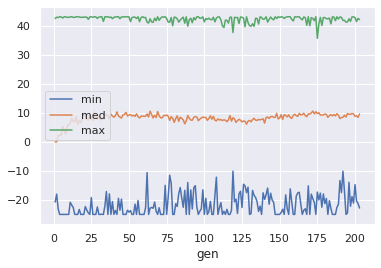

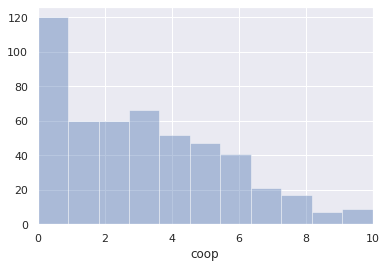

<class 'ValueError'> attempt to get argmax of an empty sequence
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmut/2020-07-23-1348/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.1_+mutPro_0.5_+mutRat_0.1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmut/2020-07-23-1348/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.1_+mutPro_0.5_+mutRat_0.1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/


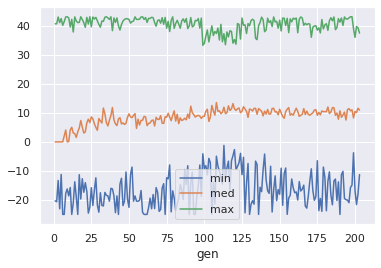

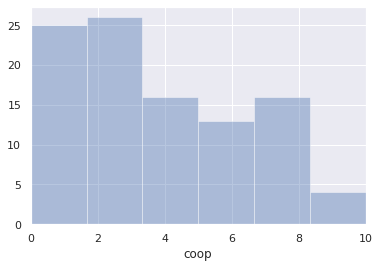

/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmut/2020-07-23-1348/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.1_+mutPro_0.5_+mutRat_0.1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/coop_149.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmut/2020-07-23-1348/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.1_+mutPro_0.5_+mutRat_0.1_+mutPro_0.5_+mutPro_0.5_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/


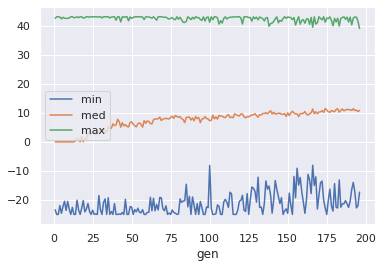

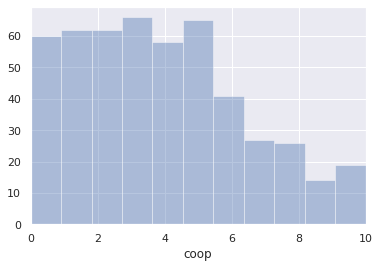

/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong-frombest/2020-07-24-1712/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_3_noneone/run_01/rep00/coop_149.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong-frombest/2020-07-24-1712/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_3_noneone/run_01/rep00/


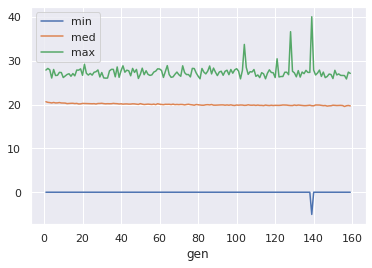

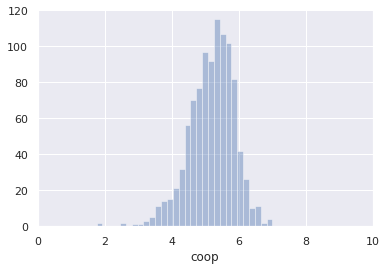

/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong-frombest/2020-07-24-1712/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_3_noneone/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong-frombest/2020-07-24-1712/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_3_noneone/run_01/rep00/


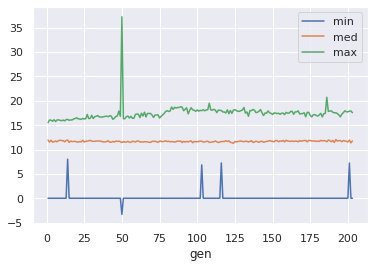

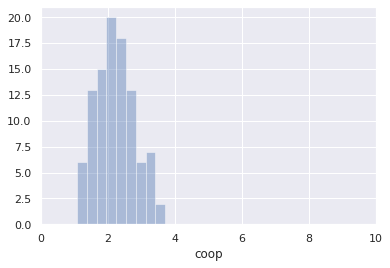

/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong-frombest/2020-07-24-1712/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_3_noneone/run_01/rep00/coop_199.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong-frombest/2020-07-24-1712/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_3_noneone/run_01/rep00/


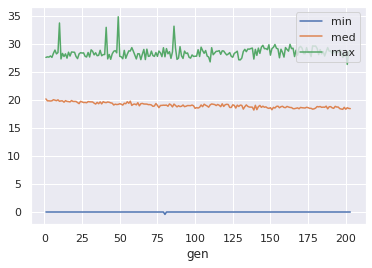

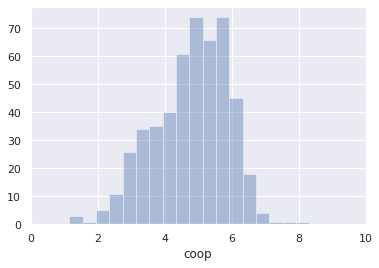

<class 'FileNotFoundError'> [Errno 2] File /home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1700/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00//../fit.txt does not exist: '/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1700/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00//../fit.txt'
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1702/+gIniti_1000_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/coop_249.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-170

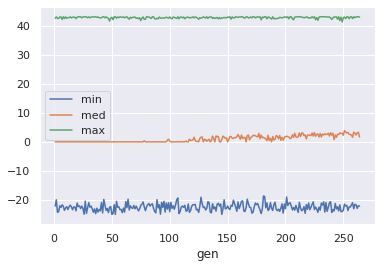

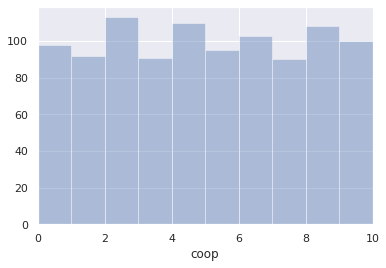

/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1702/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/coop_2699.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1702/+gIniti_100_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/


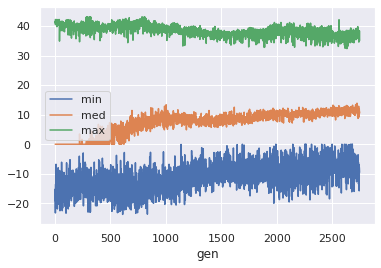

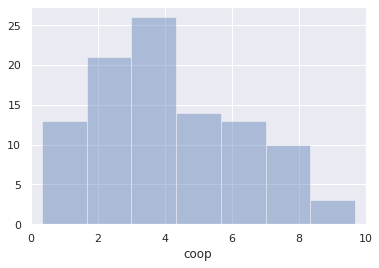

/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1702/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/coop_549.txt
/home/ecoffet/robocoop//logs/negociate25-noneone-train-okmutlong/2020-07-24-1702/+gIniti_500_+tau_0_+fakeRo_False_+mutCoo_0.01_+mutPro_0.1_+mutRat_0.01_+mutPro_0.5_+mutPro_0.1_+evalua_100000_+totalI_True_+wander_True_+putOut_False_+random_True_+train_2_noneone/run_01/rep00/


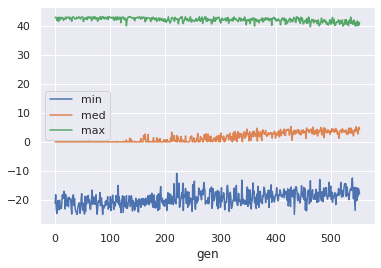

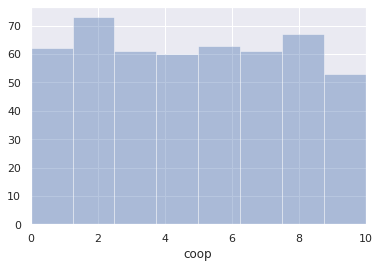

In [13]:
import json
import os
paths = sorted(glob.glob(f'{prefix}/logs/negociate25-noneone-train-*/**/run_01/rep00/', recursive=True))
#paths = sorted(glob.glob(f'{prefix}/logs/negociate20-*/**/rep00/', recursive=True))
errors = 0
coop_target = '*'
errors_path = set()
allstat = []
for path in tqdm.tqdm_notebook(paths):
    try:
        fitness = pd.read_csv(path+'/../fit.txt', delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
        coopfile = gethighest(glob.glob(path + f'/coop_*.txt'), 'coop_')
        print(coopfile)
        coop = read_csvx(coopfile, delimiter="\t")

        params = readparams(sorted(glob.glob(path + '/properties*'))[0])
        print(path)
        fitness.plot(x="gen", y=['min','med', 'max'])
        #flog = pd.read_csv(path+'/fitnesslog.txt.gz', delimiter="\t")
        #flog.groupby('gen')['fitness'].mean().plot(label='mean')
        #flog.groupby('gen')['fitness'].median().plot(label='mean')
        plt.show()
        sns.distplot(coop['coop'], kde=False)
        plt.xlim(0, 10)
        plt.show()
        params['coop'] = coop['coop'].mean()

    except Exception as e:
        print(type(e), e)
        errors+=1
        errors_path.add(os.path.dirname(os.path.dirname(os.path.dirname(path))))
        pass
    else:
        allstat.append(params)
df = pd.DataFrame(allstat)

/home/ecoffet/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


{'gInitialNumberOfRobots': 1000.0, 'tau': 0.0, 'wander': False}


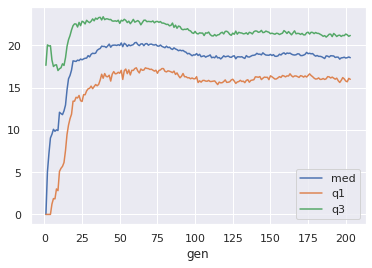

{'gInitialNumberOfRobots': 1000.0, 'tau': 0.0, 'wander': True}


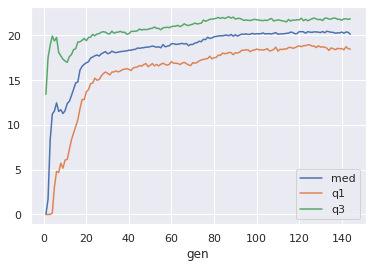

{'gInitialNumberOfRobots': 100.0, 'tau': 0.0, 'wander': False}


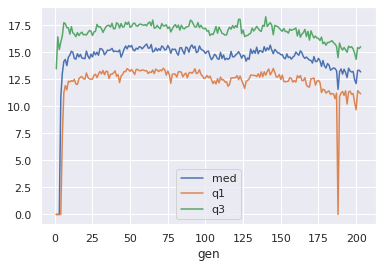

{'gInitialNumberOfRobots': 100.0, 'tau': 0.0, 'wander': True}


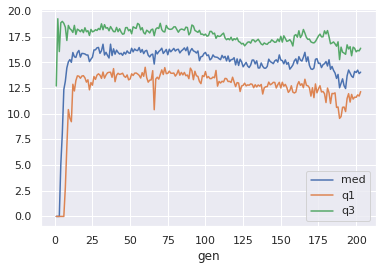

{'gInitialNumberOfRobots': 10.0, 'tau': 0.0, 'wander': False}


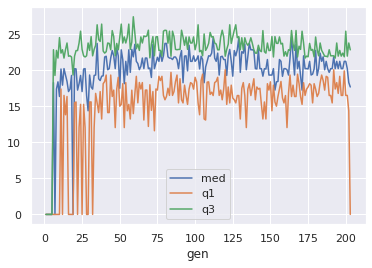

{'gInitialNumberOfRobots': 10.0, 'tau': 0.0, 'wander': True}


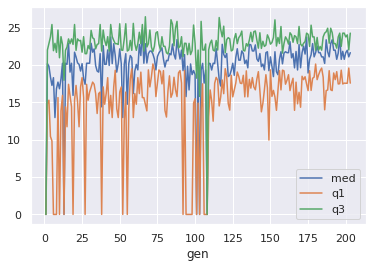

{'gInitialNumberOfRobots': 200.0, 'tau': 0.0, 'wander': False}


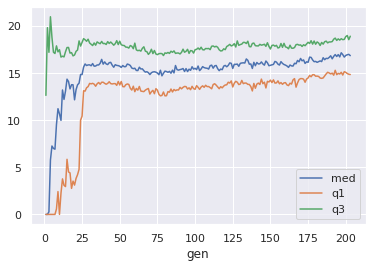

{'gInitialNumberOfRobots': 200.0, 'tau': 0.0, 'wander': True}


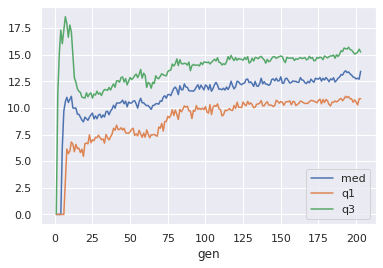

{'gInitialNumberOfRobots': 500.0, 'tau': 0.0, 'wander': False}


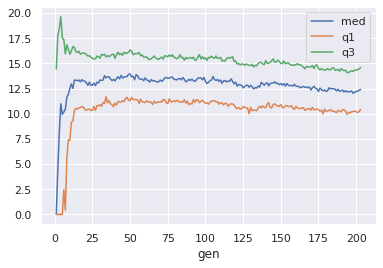

{'gInitialNumberOfRobots': 500.0, 'tau': 0.0, 'wander': True}


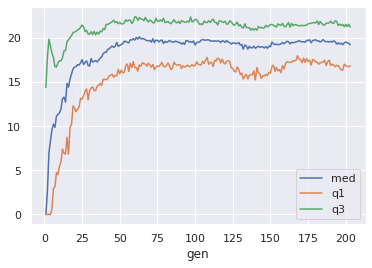

{'gInitialNumberOfRobots': 50.0, 'tau': 0.0, 'wander': False}


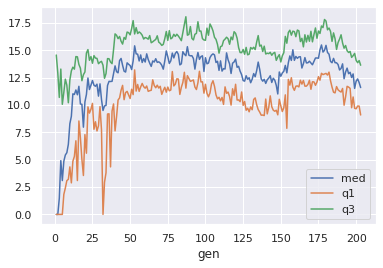

{'gInitialNumberOfRobots': 50.0, 'tau': 0.0, 'wander': True}


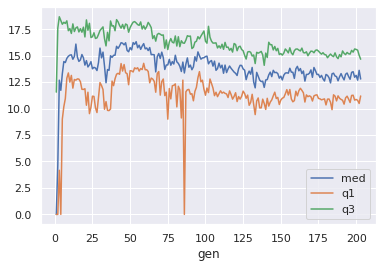

{'gInitialNumberOfRobots': 750.0, 'tau': 0.0, 'wander': False}


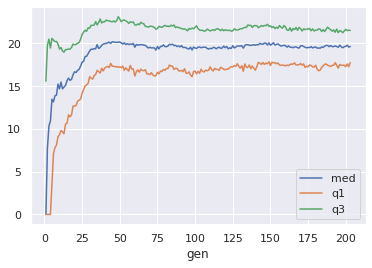

{'gInitialNumberOfRobots': 750.0, 'tau': 0.0, 'wander': True}


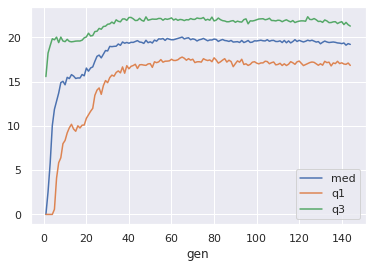

{'gInitialNumberOfRobots': 1000.0, 'tau': 100000.0, 'wander': False}


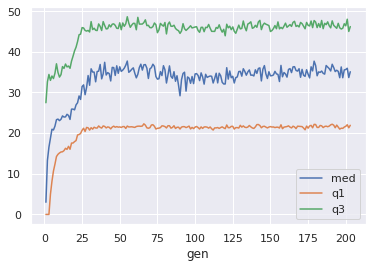

{'gInitialNumberOfRobots': 1000.0, 'tau': 100000.0, 'wander': True}


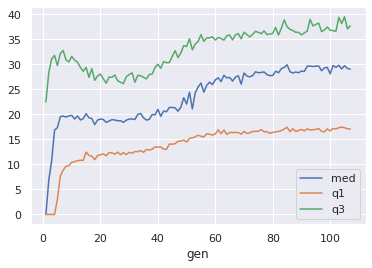

attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
{'gInitialNumberOfRobots': 100.0, 'tau': 100000.0, 'wander': False}


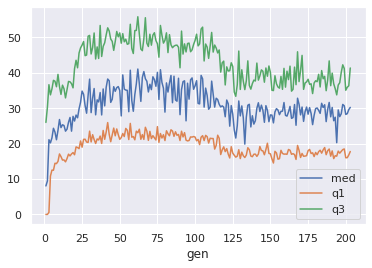

{'gInitialNumberOfRobots': 100.0, 'tau': 100000.0, 'wander': True}


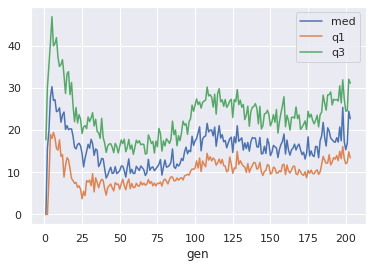

{'gInitialNumberOfRobots': 10.0, 'tau': 100000.0, 'wander': False}


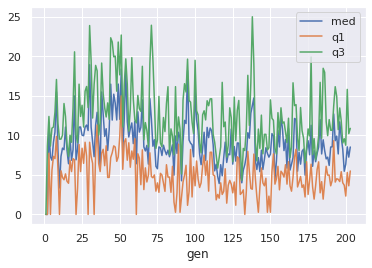

{'gInitialNumberOfRobots': 10.0, 'tau': 100000.0, 'wander': True}


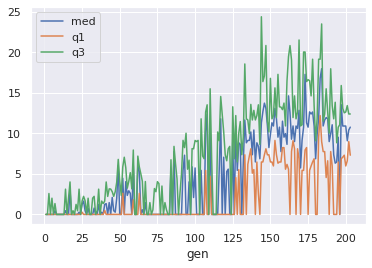

{'gInitialNumberOfRobots': 200.0, 'tau': 100000.0, 'wander': False}


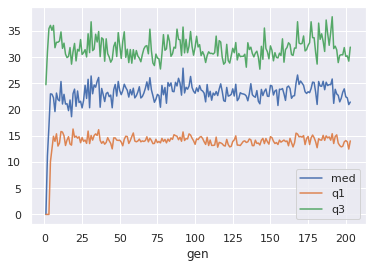

{'gInitialNumberOfRobots': 200.0, 'tau': 100000.0, 'wander': True}


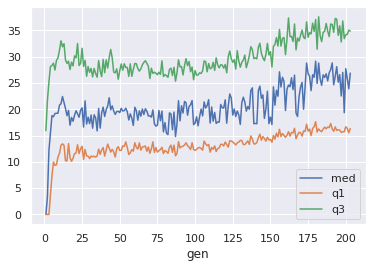

{'gInitialNumberOfRobots': 500.0, 'tau': 100000.0, 'wander': False}


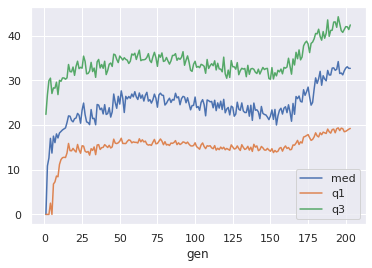

{'gInitialNumberOfRobots': 500.0, 'tau': 100000.0, 'wander': True}


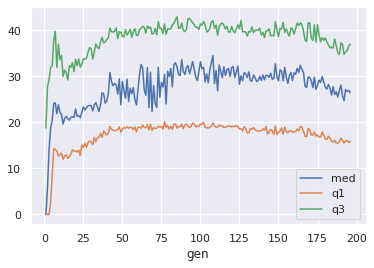

{'gInitialNumberOfRobots': 50.0, 'tau': 100000.0, 'wander': False}


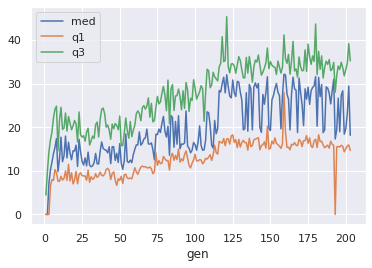

{'gInitialNumberOfRobots': 50.0, 'tau': 100000.0, 'wander': True}


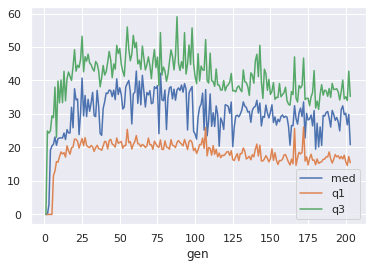

{'gInitialNumberOfRobots': 750.0, 'tau': 100000.0, 'wander': False}


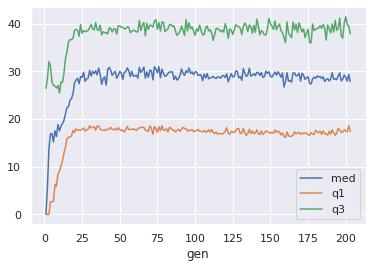

{'gInitialNumberOfRobots': 750.0, 'tau': 100000.0, 'wander': True}


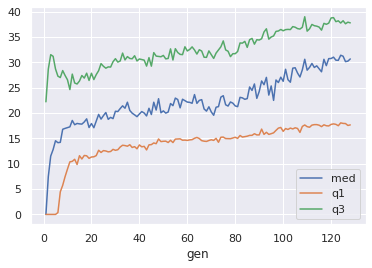

{'gInitialNumberOfRobots': 1000.0, 'tau': 1000.0, 'wander': False}


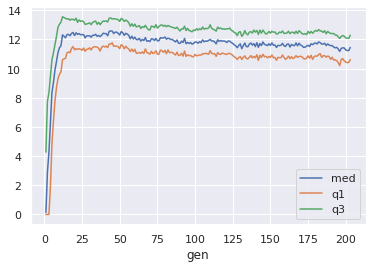

{'gInitialNumberOfRobots': 1000.0, 'tau': 1000.0, 'wander': True}


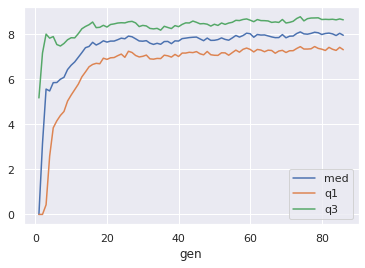

attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to 

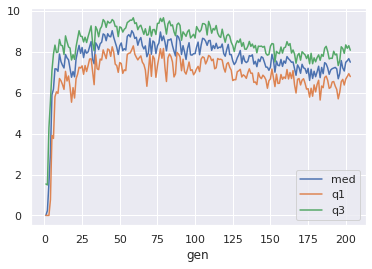

{'gInitialNumberOfRobots': 100.0, 'tau': 1000.0, 'wander': True}


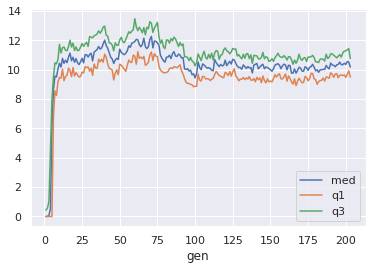

{'gInitialNumberOfRobots': 10.0, 'tau': 1000.0, 'wander': False}


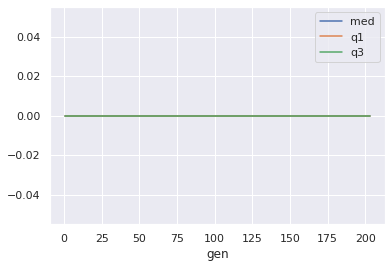

{'gInitialNumberOfRobots': 10.0, 'tau': 1000.0, 'wander': True}


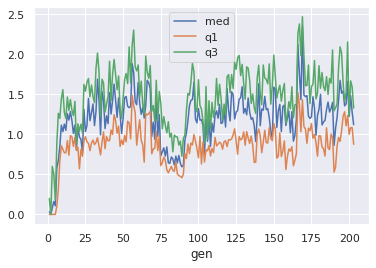

{'gInitialNumberOfRobots': 200.0, 'tau': 1000.0, 'wander': False}


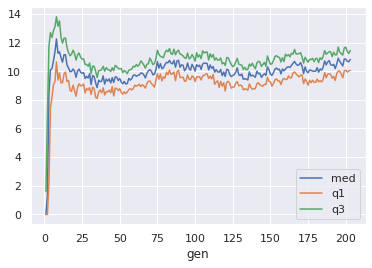

{'gInitialNumberOfRobots': 200.0, 'tau': 1000.0, 'wander': True}


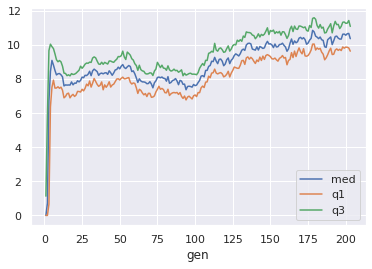

{'gInitialNumberOfRobots': 500.0, 'tau': 1000.0, 'wander': False}


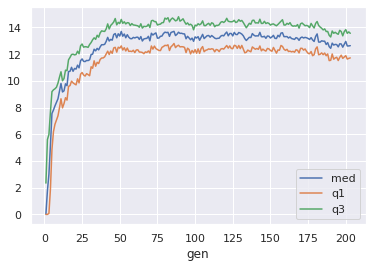

{'gInitialNumberOfRobots': 500.0, 'tau': 1000.0, 'wander': True}


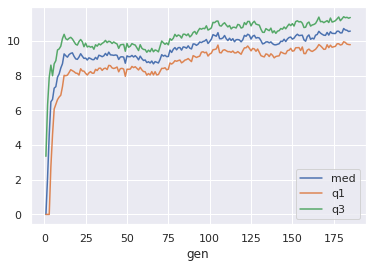

{'gInitialNumberOfRobots': 50.0, 'tau': 1000.0, 'wander': False}


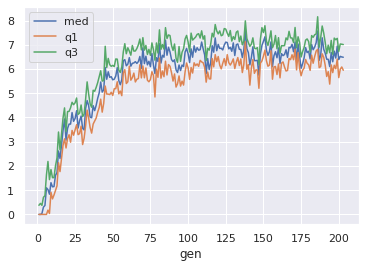

{'gInitialNumberOfRobots': 50.0, 'tau': 1000.0, 'wander': True}


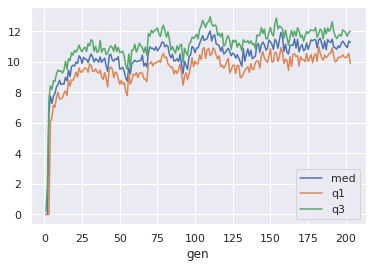

{'gInitialNumberOfRobots': 750.0, 'tau': 1000.0, 'wander': False}


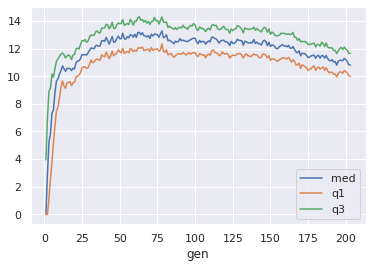

{'gInitialNumberOfRobots': 750.0, 'tau': 1000.0, 'wander': True}


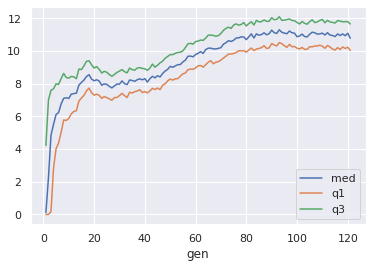

{'gInitialNumberOfRobots': 1000.0, 'tau': 50000.0, 'wander': False}


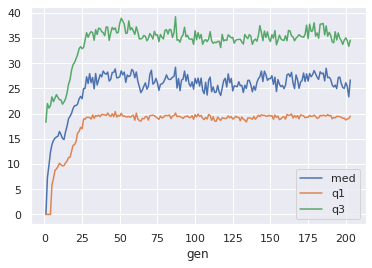

{'gInitialNumberOfRobots': 1000.0, 'tau': 50000.0, 'wander': True}


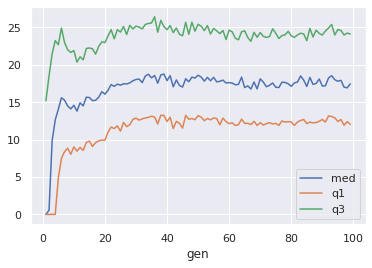

attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
attempt to get argmax of an empty sequence
{'gInitialNumberOfRobots': 100.0, 'tau': 50000.0, 'wander': False}


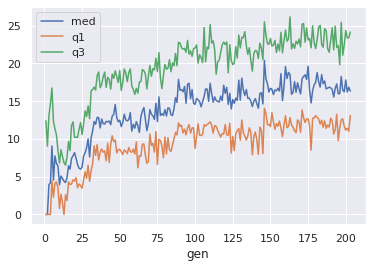

{'gInitialNumberOfRobots': 100.0, 'tau': 50000.0, 'wander': True}


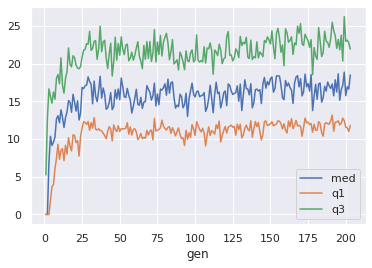

{'gInitialNumberOfRobots': 10.0, 'tau': 50000.0, 'wander': False}


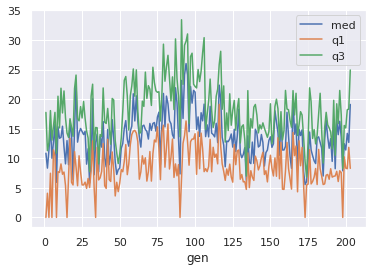

{'gInitialNumberOfRobots': 10.0, 'tau': 50000.0, 'wander': True}


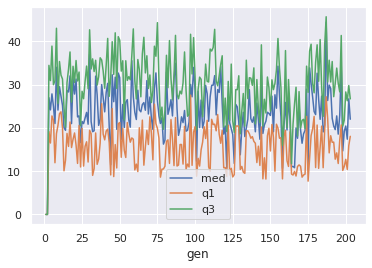

{'gInitialNumberOfRobots': 200.0, 'tau': 50000.0, 'wander': False}


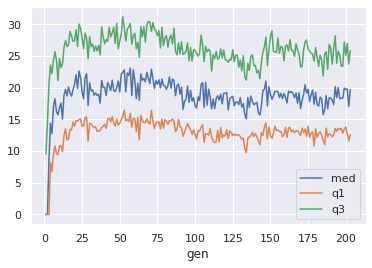

{'gInitialNumberOfRobots': 200.0, 'tau': 50000.0, 'wander': True}


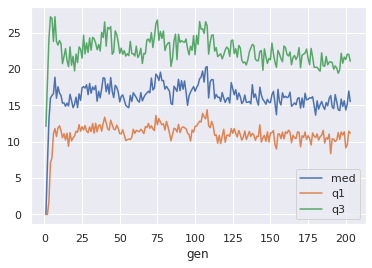

{'gInitialNumberOfRobots': 500.0, 'tau': 50000.0, 'wander': False}


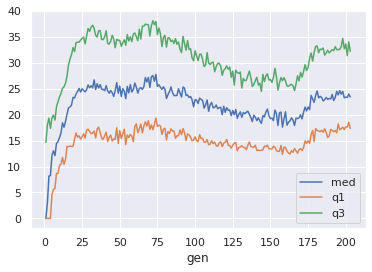

{'gInitialNumberOfRobots': 500.0, 'tau': 50000.0, 'wander': True}


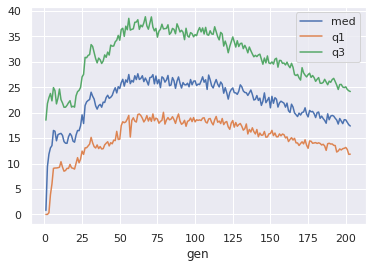

{'gInitialNumberOfRobots': 50.0, 'tau': 50000.0, 'wander': False}


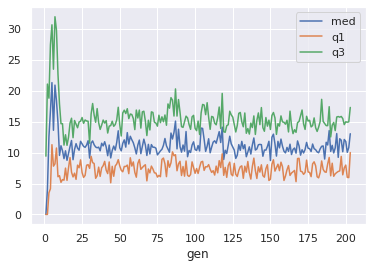

{'gInitialNumberOfRobots': 50.0, 'tau': 50000.0, 'wander': True}


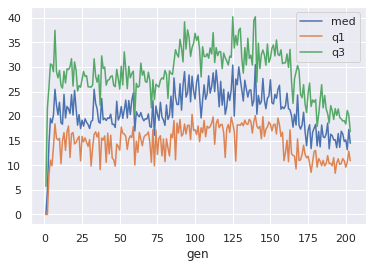

{'gInitialNumberOfRobots': 750.0, 'tau': 50000.0, 'wander': False}


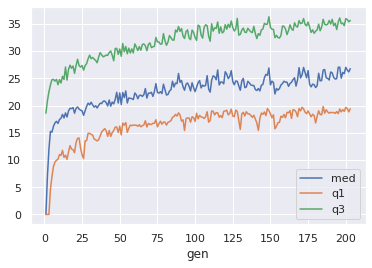

{'gInitialNumberOfRobots': 750.0, 'tau': 50000.0, 'wander': True}


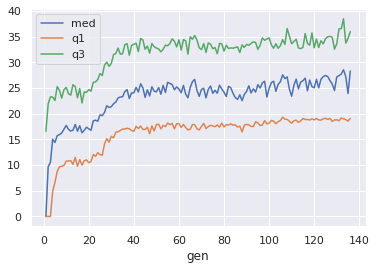

In [56]:
import json
import os
paths = sorted(glob.glob(f'{prefix}/logs/negociate22*/**/rep00/', recursive=True))
#paths = sorted(glob.glob(f'{prefix}/logs/negociate20-*/**/rep00/', recursive=True))
errors = 0
coop_target = 99
errors_path = set()
allstat = []
for path in tqdm.tqdm_notebook(paths):
    try:
        fitness = read_csvx(path+'/../fit.txt', delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
        
        params = readparams(sorted(glob.glob(path + '/properties*'))[0])
        if 'run_00' in path:
            print({key: val for key, val in params.items() if key in ['gInitialNumberOfRobots', 'tau', 'wander']})
            fitness.plot(x="gen", y=['med', 'q1', 'q3'])
            #flog = pd.read_csv(path+'/fitnesslog.txt.gz', delimiter="\t")
            #flog.groupby('gen')['fitness'].mean().plot(label='mean')
            #flog.groupby('gen')['fitness'].median().plot(label='mean')
            plt.show()
            #sns.distplot(coop['coop'])
            #plt.show()
        coop = read_csvx(gethighest(glob.glob(path + f'/coop_{coop_target}.txt'), 'coop_'), delimiter="\t")
        params['coop'] = coop['coop'].mean()

    except Exception as e:
        print(e)
        errors+=1
        errors_path.add(os.path.dirname(os.path.dirname(os.path.dirname(path))))
        pass
    else:
        allstat.append(params)
df = pd.DataFrame(allstat)

In [60]:
print(f"{errors / (errors + len(df)):.1%}")
print('\n'.join(errors_path))


0.0%



In [61]:
df['nbRobots'] = df['gInitialNumberOfRobots']
df['varPheno'] = df['fakeRobots']
df['nbRep'] = df['nbEvaluationsPerGeneration']
df['norm_tau'] = df['tau'] / 100000
df['norm_tau'] = df['norm_tau'].replace(0, 1)

In [62]:
g = sns.relplot(data=df, x='nbRobots', y='coop', row='tau', col='wander', aspect=1.5, kind="line")
g.map_dataframe(sns.scatterplot, x="nbRobots", y="coop")
#g.map_dataframe(sns.scatterplot, x="maxPlayer", y="truecoopmod", color="green")

#g.map_dataframe(plot_ess,  color=defectColor.hex, label="defect investment")
#g.map_dataframe(plot_so,  color=coopColor.hex, label="social optimum investment")
#g.map_dataframe(plot_span)
#g.map(annotator, itera=iter(string.ascii_lowercase))
#g.set(ylabel='Mean investment for $\hat{n}$', xlabel="Number of agents in the environment")
#g.set_titles("$\omega = {col_name} | \hat{{n}} = {row_name}$")

#g.set_xlabel('Number of agents in the environment')
g.add_legend()

KeyError: 'wander'

In [57]:
df.query('tau == 10000')

,ConfigurationLoaderObjectName,SlowMotionMode,VisibleLandmarks,aAsInput,additiveVar,arrivalAsInput,atLeastTwo,availableslot[0].x,availableslot[0].y,availableslot[10].x,...,tau,teleportRobots,totalInvAsInput,tpToNewObj,wander,coop,nbRobots,varPheno,nbRep,norm_tau


In [58]:
import json
paths = sorted(glob.glob(f'{prefix}/logs/negociate22*/**/rep00/', recursive=True))

allstat = []
for path in tqdm.tqdm_notebook(paths):
    try:
        fitness = read_csvx(path+'/../fit.txt', delimiter="\t", names=['gen', 'min', 'q1', 'med', 'q3', 'max'])
        params = readparams(sorted(glob.glob(path + '/properties*'))[0])
        coop = read_csvx(gethighest(glob.glob(path + '/coop_199.txt'), 'coop_'), delimiter="\t")
        params['coop'] = coop['coop'].mean()
    except Exception as e:
        #print('no analysis for',  path)
       # print(type(e), ':', e)
        pass
    else:
        allstat.append(params)
df = pd.DataFrame(allstat)

In [59]:
df['nbRobots'] = df['gInitialNumberOfRobots']
df['varPheno'] = df['fakeRobots']
df['nbRep'] = df['nbEvaluationsPerGeneration']
df['norm_tau'] = df['tau'] / 100000
df['norm_tau'] = df['norm_tau'].replace(0, 1)

In [60]:
for col in df:
    if len(df[col].unique()) > 1:
        print (col, df[col].unique())

gInitialNumberOfRobots [1000.  100.   10.  200.  500.   50.  750.]
gLogFilename ['datalog_20200129-10h47m13s589313us_5721.txt'
 'datalog_20200129-10h47m13s588630us_5740.txt'
 'datalog_20200129-10h47m13s588977us_5735.txt' ...
 'datalog_20200131-04h21m50s721376us_31755.txt'
 'datalog_20200131-04h21m50s720886us_31758.txt'
 'datalog_20200131-04h21m50s720860us_31752.txt']
gRandomSeed [9.66716687e+08 9.66716915e+08 9.66717042e+08 ... 3.20012921e+08
 3.20012232e+08 3.20012467e+08]
putOutOfGame [ True False]
randomObjectPositions [False  True]
tau [     0. 100000.   1000.  50000.]
wander [False  True]
coop [4.58920294 4.61071014 5.67209752 ... 4.33712652 5.15352799 4.59145667]
nbRobots [1000.  100.   10.  200.  500.   50.  750.]
norm_tau [1.   0.01 0.5 ]


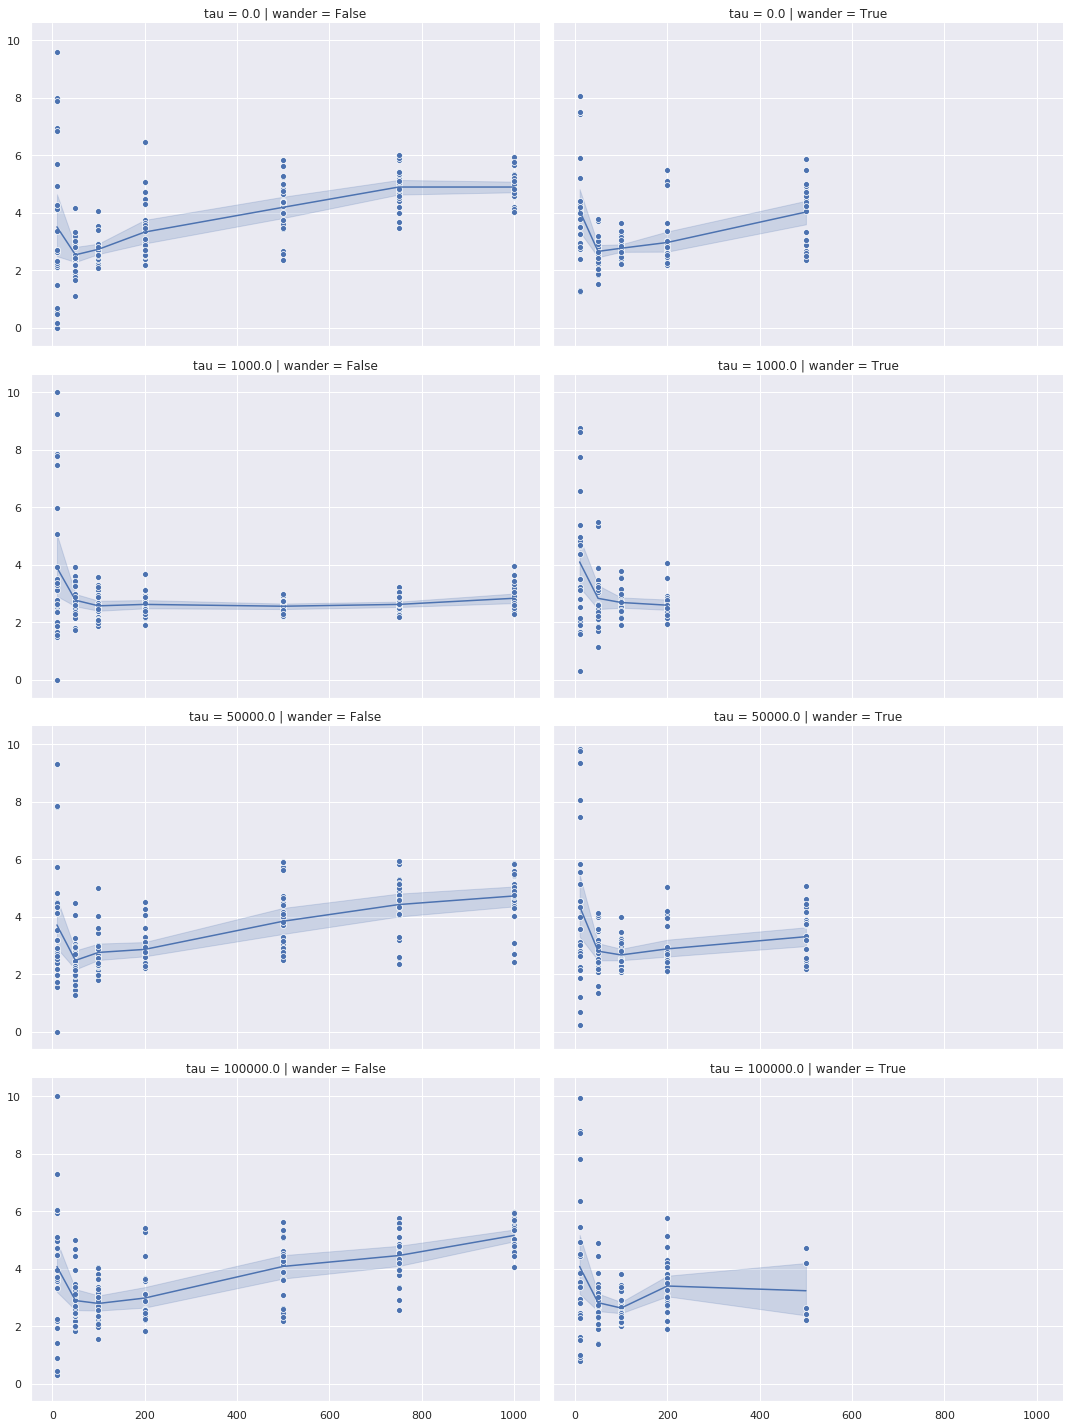

In [61]:
g = sns.relplot(data=df, x='nbRobots', y='coop', row='tau', col='wander', aspect=1.5, kind="line")
g.map_dataframe(sns.scatterplot, x="nbRobots", y="coop")
#g.map_dataframe(sns.scatterplot, x="maxPlayer", y="truecoopmod", color="green")

#g.map_dataframe(plot_ess,  color=defectColor.hex, label="defect investment")
#g.map_dataframe(plot_so,  color=coopColor.hex, label="social optimum investment")
#g.map_dataframe(plot_span)
#g.map(annotator, itera=iter(string.ascii_lowercase))
#g.set(ylabel='Mean investment for $\hat{n}$', xlabel="Number of agents in the environment")
#g.set_titles("$\omega = {col_name} | \hat{{n}} = {row_name}$")

#g.set_xlabel('Number of agents in the environment')
g.add_legend()